## Insilico digest preparation
Download of the reference data from the UCSC and setting up a BSgenome package for each species for the analysis of the insilico RRBS  
Author: Daria Romanovskaia dromanovskaia@cemm.at  
Date: 22.12.2020 (upd. 1.02.2021)

In [24]:
library(Biostrings)
library(rtracklayer)
library(BSgenome)
library(dplyr)
library(ggplot2)
library(data.table)

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which, which.max, which.min


Loading required package: S4Vectors

Loading required package: stats4


Attaching package: ‘S4Vectors’


The

## Set of species to analyse:  

We have defined a set of speices, that are of potential interest for us as they have avaliable genomes + needed annotation tracks.
First version of the validation_species contained only the species name and the class and was further annotated along this notebook

In [6]:
getwd()

[1] "/data/groups/lab_bock/dromanovskaia/projects/DNAmeth500species/validation/src"

In [27]:
df <- read.csv("../meta/validation_species.csv", sep = ";")
head(df)

,species,ucsc_genome,class,scientific_name
,<chr>,<chr>,<chr>,<chr>
1,Human,hg38,Mammalia,Homo sapiens
2,Mouse,mm10,Mammalia,Mus musculus
3,Zebrafish,danRer11,Actinopteri,Danio rerio
4,Lancelet,braFlo1,Invertebrata,Cephalochordata
5,Sea Hare,aplCal1,Invertebrata,Aplysia californica
6,Lamprey,petMar2,Jawless Vertebrate,Petromyzon marinus


In [75]:
output_dir <- "/scratch/lab_bock/shared/projects/compEpi/validation/insilicoDigest/"

## Adding information from BSgenome and UCSC

#### Pre-existing genome packages

Step 1: figuring out which genomes are available

In [29]:
av_gen <- available.genomes(splitNameParts=TRUE)
table(av_gen$organism)


      Alyrata    Amellifera  Aofficinalis     Athaliana       Btaurus 
            1             4             1             2             8 
   Carietinum      Celegans   Cfamiliaris      Cjacchus  Creinhardtii 
            1             4             4             1             1 
Dmelanogaster        Drerio      Dvirilis         Ecoli    Gaculeatus 
            5             8             1             1             2 
      Ggallus      Hsapiens    Mdomestica Mfascicularis         Mfuro 
            6            10             1             1             1 
     Mmulatta     Mmusculus       Osativa     Ppaniscus  Ptroglodytes 
            6             6             1             2             6 
  Rnorvegicus   Scerevisiae       Sscrofa       Tgondii      Tguttata 
            5             3             3             1             3 
    Vvinifera 
            3 

Using rtacklayer we generate a dataframe of genomes, avaliable at UCSC:

In [30]:
genomes_avail <- ucscGenomes()

Being paranoid, I have manually selected the genome versions for each species. Just subsetting the dataframe, preordered by the time (to take the latest) qould also do.

In [31]:
head(genomes_avail)

,db,species,date,name
,<chr>,<chr>,<chr>,<chr>
1,hg38,Human,Dec. 2013,Genome Reference Consortium GRCh38
2,hg19,Human,Feb. 2009,Genome Reference Consortium GRCh37
3,hg18,Human,Mar. 2006,NCBI Build 36.1
4,hg17,Human,May 2004,NCBI Build 35
5,hg16,Human,Jul. 2003,NCBI Build 34
6,vicPac2,Alpaca,Mar. 2013,Broad Institute Vicugna_pacos-2.0.1


Adding the information about the official name and the release name

In [32]:
df <- left_join(df, genomes_avail[genomes_avail$db %in% df$ucsc_genome,], by = c("ucsc_genome" = "db", "species" = "species") )

In [33]:
head(df)

,species,ucsc_genome,class,scientific_name,date,name
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,Human,hg38,Mammalia,Homo sapiens,Dec. 2013,Genome Reference Consortium GRCh38
2,Mouse,mm10,Mammalia,Mus musculus,Dec. 2011,Genome Reference Consortium GRCm38
3,Zebrafish,danRer11,Actinopteri,Danio rerio,May 2017,Genome Reference Consortium GRCz11
4,Lancelet,braFlo1,Invertebrata,Cephalochordata,Mar. 2006,JGI v1.0
5,Sea Hare,aplCal1,Invertebrata,Aplysia californica,Sep. 2008,Broad Release Aplcal2.0
6,Lamprey,petMar2,Jawless Vertebrate,Petromyzon marinus,Sep. 2010,WUGSC 7.0


In [36]:
packages <- av_gen[av_gen$genome %in% df$ucsc_genome,]

In [38]:
colnames(packages) <- c("BSlibrary", "genome_id", "provider", "ucsc_genome", "masked")

In [39]:
head(df)

,species,ucsc_genome,class,scientific_name,date,name
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,Human,hg38,Mammalia,Homo sapiens,Dec. 2013,Genome Reference Consortium GRCh38
2,Mouse,mm10,Mammalia,Mus musculus,Dec. 2011,Genome Reference Consortium GRCm38
3,Zebrafish,danRer11,Actinopteri,Danio rerio,May 2017,Genome Reference Consortium GRCz11
4,Lancelet,braFlo1,Invertebrata,Cephalochordata,Mar. 2006,JGI v1.0
5,Sea Hare,aplCal1,Invertebrata,Aplysia californica,Sep. 2008,Broad Release Aplcal2.0
6,Lamprey,petMar2,Jawless Vertebrate,Petromyzon marinus,Sep. 2010,WUGSC 7.0


In [42]:
annot_full <- full_join(df, packages[!packages$masked, c(1:4)])
head(annot_full)

Joining, by = "ucsc_genome"



,species,ucsc_genome,class,scientific_name,date,name,BSlibrary,genome_id,provider
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<fct>,<fct>
1,Human,hg38,Mammalia,Homo sapiens,Dec. 2013,Genome Reference Consortium GRCh38,BSgenome.Hsapiens.UCSC.hg38,Hsapiens,UCSC
2,Mouse,mm10,Mammalia,Mus musculus,Dec. 2011,Genome Reference Consortium GRCm38,BSgenome.Mmusculus.UCSC.mm10,Mmusculus,UCSC
3,Zebrafish,danRer11,Actinopteri,Danio rerio,May 2017,Genome Reference Consortium GRCz11,BSgenome.Drerio.UCSC.danRer11,Drerio,UCSC
4,Lancelet,braFlo1,Invertebrata,Cephalochordata,Mar. 2006,JGI v1.0,NA,NA,NA
5,Sea Hare,aplCal1,Invertebrata,Aplysia californica,Sep. 2008,Broad Release Aplcal2.0,NA,NA,NA
6,Lamprey,petMar2,Jawless Vertebrate,Petromyzon marinus,Sep. 2010,WUGSC 7.0,NA,NA,NA


In [43]:
write.table(annot_full, "validation_species_resources.csv", sep = ";", quote = F, row.names = F)

## Preparing the setup
For each of the species we need to prepare a BSGenome package and download all the tracks

### BSGenomes:

Checking if we need to install missing BSGenome packages:

In [1]:
df <- read.csv("validation_species_resources.csv", sep = ";", stringsAsFactors = FALSE)

In [2]:
head(df)

species,ucsc_genome,class,scientific_name,date,name,BSlibrary,genome_id,provider
Human,hg38,Mammalia,Homo sapiens,Dec. 2013,Genome Reference Consortium GRCh38,BSgenome.Hsapiens.UCSC.hg38,Hsapiens,UCSC
Mouse,mm10,Mammalia,Mus musculus,Dec. 2011,Genome Reference Consortium GRCm38,BSgenome.Mmusculus.UCSC.mm10,Mmusculus,UCSC
Zebrafish,danRer11,Actinopteri,Danio rerio,May 2017,Genome Reference Consortium GRCz11,BSgenome.Drerio.UCSC.danRer11,Drerio,UCSC
Lancelet,braFlo1,Invertebrata,Cephalochordata,Mar. 2006,JGI v1.0,NA,NA,NA
Sea Hare,aplCal1,Invertebrata,Aplysia californica,Sep. 2008,Broad Release Aplcal2.0,NA,NA,NA
Lamprey,petMar2,Jawless Vertebrate,Petromyzon marinus,Sep. 2010,WUGSC 7.0,NA,NA,NA


In [45]:
for (BSlibrary in na.omit(df$BSlibrary)) {
    result <- tryCatch({
    library(BSlibrary, character.only = TRUE)
        }, warning = function(w) {
    print("some warnings there")
        }, error = function(e) {
        print(paste0("installing missing package ", BSlibrary))
        BiocManager::install(BiocManager::install(BSlibrary, character.only = TRUE))
        library(BSlibrary, character.only = TRUE)
    }, finally = {
    print(paste0("package installed ", BSlibrary))
    })
    }

[1] "installing missing package BSgenome.Hsapiens.UCSC.hg38"


Bioconductor version 3.12 (BiocManager 1.30.10), R 4.0.3 (2020-10-10)

Installing package(s) 'BSgenome.Hsapiens.UCSC.hg38'

Installation path not writeable, unable to update packages: actuar, affy,
  affyio, akima, ALL, alpaca, amap, AmesHousing, annotate, AnnotationDbi, ape,
  arm, arules, ascii, backports, bibtex, bife, biglm, Biobase, BiocGenerics,
  BiocParallel, BiocStyle, Biostrings, bit, bit64, bladderbatch, bookdown,
  boot, brglm, bst, Cairo, callr, candisc, car, carData, caTools, CDM,
  checkmate, chron, class, classInt, cli, cliapp, clipr, clubSandwich, clue,
  clValid, cmprsk, coda, codetools, colorspace, colourpicker, cowplot,
  crosstalk, cubature, DAAG, dada2, data.tree, dbplyr, DelayedArray, deldir,
  dendextend, Deriv, deSolve, devEMF, dfoptim, DiceKriging, diffobj, digest,
  directlabels, dismo, doMC, doParallel, dplyr, DT, dtplyr, dtw, DynDoc, e1071,
  earth, edgeR, effects, eha, elasticnet, ellipse, ellipsis, emmeans, emoa,
  expm, extraDistr, FactoMineR, fBasics, f

[1] "package installed BSgenome.Hsapiens.UCSC.hg38"
[1] "installing missing package BSgenome.Mmusculus.UCSC.mm10"


Bioconductor version 3.12 (BiocManager 1.30.10), R 4.0.3 (2020-10-10)

Installing package(s) 'BSgenome.Mmusculus.UCSC.mm10'

Warning message in install.packages(...):
“installation of package ‘BSgenome.Mmusculus.UCSC.mm10’ had non-zero exit status”
Installation path not writeable, unable to update packages: actuar, affy,
  affyio, akima, ALL, alpaca, amap, AmesHousing, annotate, AnnotationDbi, ape,
  arm, arules, ascii, backports, bibtex, bife, biglm, Biobase, BiocGenerics,
  BiocParallel, BiocStyle, Biostrings, bit, bit64, bladderbatch, bookdown,
  boot, brglm, bst, Cairo, callr, candisc, car, carData, caTools, CDM,
  checkmate, chron, class, classInt, cli, cliapp, clipr, clubSandwich, clue,
  clValid, cmprsk, coda, codetools, colorspace, colourpicker, cowplot,
  crosstalk, cubature, DAAG, dada2, data.tree, dbplyr, DelayedArray, deldir,
  dendextend, Deriv, deSolve, devEMF, dfoptim, DiceKriging, diffobj, digest,
  directlabels, dismo, doMC, doParallel, dplyr, DT, dtplyr, dtw, DynDoc, 

ERROR: Error in library(BSlibrary, character.only = TRUE): there is no package called ‘BSgenome.Mmusculus.UCSC.mm10’


[1] "package installed BSgenome.Mmusculus.UCSC.mm10"


### Self-making the non-provided packages

For the non-existing genomes we will forge the BSgenomes from the sequences, downloaded from UCSC  
Detailed explanation can be found here: https://bioconductor.org/packages/release/bioc/vignettes/BSgenome/inst/doc/BSgenomeForge.pdf

In [24]:
head(df)

species,ucsc_genome,class,scientific_name,date,name,BSlibrary,genome_id,provider
Mouse,mm10,Mammalia,Mus musculus,Dec. 2011,Genome Reference Consortium GRCm38,BSgenome.Mmusculus.UCSC.mm10,Mmusculus,UCSC
Zebrafish,danRer11,Actinopteri,Danio rerio,May 2017,Genome Reference Consortium GRCz11,BSgenome.Drerio.UCSC.danRer11,Drerio,UCSC
Lancelet,braFlo1,Invertebrata,Cephalochordata,Mar. 2006,JGI v1.0,NA,NA,NA
Sea Hare,aplCal1,Invertebrata,Aplysia californica,Sep. 2008,Broad Release Aplcal2.0,NA,NA,NA
Lamprey,petMar2,Jawless Vertebrate,Petromyzon marinus,Sep. 2010,WUGSC 7.0,NA,NA,NA
Elephant shark,calMil1,Chondrichthyes,Callorhinchus milii,Dec. 2013,IMCB Callorhinchus_milli_6.1.3,NA,NA,NA


In [25]:
df_toforge <- df[is.na(df$BSlibrary),]

In [26]:
setDT(df_toforge)

In [27]:
df_toforge[,provider:="custom_from_UCSC",]

#### Step 1: download the genome sequences

We will download the 2bit files from the bigZip repository of the UCSC and place them into data/genome/genome_id 
The wget link is designed as http://hgdownload.soe.ucsc.edu/goldenPath/uscs_genome/bigZips/ucsc_genome.2bit  

The genome_id is combined as the first letter of the first word of the latin names plus the last

In [20]:
generate_genome_id <- function(id){
    print(id)
    id_split <- strsplit(as.character(id), split = " ")[[1]]
    l <- length(id_split)
    print(id_split[1])
    if( l == 1 ){
        return(id_split[1])
    }else if( l > 1 ){
        genome_id <- paste0(substr(id_split[1],1,1), id_split[l])
        print(genome_id)
        return(genome_id)
    }else{
        print("no latin name passed!")
        return("0")
    }
}

In [21]:
df_toforge$genome_id <- as.character(df_toforge$genome_id)

In [28]:
df_toforge[, genome_id:=generate_genome_id(scientific_name),by = 1:NROW(df_toforge)]

[1] "Cephalochordata"
[1] "Cephalochordata"
[1] "Aplysia californica"
[1] "Aplysia"
[1] "Acalifornica"
[1] "Petromyzon marinus"
[1] "Petromyzon"
[1] "Pmarinus"
[1] "Callorhinchus milii"
[1] "Callorhinchus"
[1] "Cmilii"
[1] "Gadus morhua"
[1] "Gadus"
[1] "Gmorhua"
[1] "Oreochromis niloticus"
[1] "Oreochromis"
[1] "Oniloticus"
[1] "Takifugu rubripes"
[1] "Takifugu"
[1] "Trubripes"
[1] "Latimeria chalumnae"
[1] "Latimeria"
[1] "Lchalumnae"
[1] "Xenopus tropicalis "
[1] "Xenopus"
[1] "Xtropicalis"
[1] "Xenopus laevis"
[1] "Xenopus"
[1] "Xlaevis"
[1] "Nanorana parkeri"
[1] "Nanorana"
[1] "Nparkeri"
[1] "Alligator mississippiensis"
[1] "Alligator"
[1] "Amississippiensis"
[1] "Thamnophis sirtalis"
[1] "Thamnophis"
[1] "Tsirtalis"
[1] "Anolis carolinensis"
[1] "Anolis"
[1] "Acarolinensis"
[1] "Chrysemys picta"
[1] "Chrysemys"
[1] "Cpicta"
[1] "Geospiza fortis"
[1] "Geospiza"
[1] "Gfortis"
[1] "Melopsittacus undulatus"
[1] "Melopsittacus"
[1] "Mundulatus"
[1] "Aquila chrysaetos"
[1] "Aquila"
[1

Downloading all the nessesary genomes from UCSC:  
run once!

In [174]:
for (i in 1:NROW(df_toforge)){
    dir.create(file.path(output_dir, "data", "genomes", df_toforge[i, ]$genome_id))
    cmd = paste0("wget http://hgdownload.soe.ucsc.edu/goldenPath/", df_toforge[i, ]$ucsc_genome, 
                 "/bigZips/", df_toforge[i, ]$ucsc_genome, ".2bit  -P ", 
                 file.path(output_dir, "data", "genomes", df_toforge[i, ]$genome_id))
    system(cmd)
    print(df_toforge[i, ]$species)

}

[1] Elephant shark
47 Levels: African clawed frog American alligator Atlantic cod ... Zebrafish
[1] Atlantic cod
47 Levels: African clawed frog American alligator Atlantic cod ... Zebrafish
[1] Nile tilapia
47 Levels: African clawed frog American alligator Atlantic cod ... Zebrafish
[1] Fugu
47 Levels: African clawed frog American alligator Atlantic cod ... Zebrafish
[1] Coelacanth
47 Levels: African clawed frog American alligator Atlantic cod ... Zebrafish
[1] Tropical clawed frog
47 Levels: African clawed frog American alligator Atlantic cod ... Zebrafish
[1] African clawed frog
47 Levels: African clawed frog American alligator Atlantic cod ... Zebrafish
[1] Tibetan frog
47 Levels: African clawed frog American alligator Atlantic cod ... Zebrafish
[1] American alligator
47 Levels: African clawed frog American alligator Atlantic cod ... Zebrafish
[1] Garter snake
47 Levels: African clawed frog American alligator Atlantic cod ... Zebrafish
[1] Lizard
47 Levels: African clawed frog Ameri

#### prepare instruction files and compile packages

Example seed file:  
Package: BSgenome.Mfuro.UCSC.musFur1 -> BSGenome +  genome_id + UCSC + ucsc_genome  
Title: Full genome sequences for Mustela putorius furo (UCSC version musFur1)  
Description: Full genome sequences for Mustela putorius furo (Ferret) as provided by UCSC (musFur1, Apr. 2011) and stored in Biostrings objects.  
Version: 1.4.2  
organism: Mustela putorius furo  
common_name: Ferret  
provider: UCSC  
provider_version: musFur1  
release_date: Apr. 2011  
release_name: Ferret Genome Sequencing Consortium MusPutFur1.0  
source_url: http://hgdownload.soe.ucsc.edu/goldenPath/musFur1/bigZips/  
organism_biocview: Mustela_furo  
BSgenomeObjname: Mfuro  
SrcDataFiles: musFur1.2bit from http://hgdownload.soe.ucsc.edu/goldenPath/musFur1/bigZips/  
PkgExamples: genome$GL896898 # same as genome[["GL896898"]] -> not needed  
seqs_srcdir: /fh/fast/morgan_m/BioC/BSgenomeForge/srcdata/BSgenome.Mfuro.UCSC.musFur1/seqs  
seqfile_name: musFur1.2bit  

In [29]:
i = 1

In [192]:
df_toforge[i,]

species,ucsc_genome,class,scientific_name,date,name,BSlibrary,genome_id,provider
Lancelet,braFlo1,Invertebrata,Cephalochordata,Mar. 2006,JGI v1.0,NA,Cephalochordata,custom_from_UCSC


In [183]:
df_toforge$ucsc_genome <- as.character(df_toforge$ucsc_genome)

In [186]:
df_toforge$scientific_name <- as.character(df_toforge$scientific_name)

In [207]:
df_toforge$species <- as.character(df_toforge$species)
df_toforge$date <- as.character(df_toforge$date)
df_toforge$name <- as.character(df_toforge$name)

In [211]:
gsub(" ", "_",df_toforge[2,]$scientific_name)

[1] "Aplysia_californica"

In [30]:
package_name = paste(c("BSgenome", df_toforge[i,]$genome_id, "UCSC", df_toforge[i,]$ucsc_genome), collapse=".")

In [50]:
for (i in 1:NROW(df_toforge)){
    
    print(paste0(i," ", df_toforge[i, ]$genome_id))
    
    ###where to save the output
    seed_dir = file.path(output_dir, "data", "genomes", df_toforge[i, ]$genome_id)
    seed_file = file.path(seed_dir, paste0(df_toforge[i,]$ucsc_genome, "_seed.txt"))

    package_name = paste(c("BSgenome", df_toforge[i,]$genome_id, "UCSC", df_toforge[i,]$ucsc_genome), collapse=".")
    
    #as we run several time - first check, maybe it is already installed
    result <- tryCatch( { library(package_name, character.only = TRUE)  }, 
                       warning = function(w) {
                        print("w")}, 
                       error = function(e) { # if unavaliable - set it up 
                        print(paste0("settung up the genome for ", df_toforge[i, ]$genome_id))
                           #generating seed file
                        cat(c(paste0("Package: ", package_name), 
                        paste(c("Title: Full genome sequences for ", df_toforge[i,]$scientific_name, " (UCSC version ", df_toforge[i,]$ucsc_genome, ")"), collapse="" ),
                        paste(c("Description: Full genome sequences for ",  df_toforge[i,]$scientific_name, " (", df_toforge[i,]$species, ") as provided by UCSC (", 
                                  df_toforge[i,]$ucsc_genome, ", ", df_toforge[i,]$date, ") and stored in Biostrings objects."   ), collapse=""),
                        "Version: 1.1.1",
                        paste(c("organism: ", df_toforge[i,]$scientific_name), collapse=""),
                        paste(c("common_name: ", df_toforge[i,]$species), collapse=""),
                        "provider: UCSC",
                        paste(c("provider_version: ", df_toforge[i,]$ucsc_genome), collapse=""),
                        paste(c("release_date: ",df_toforge[i,]$date ), collapse=""),
                        paste(c("release_name: ", df_toforge[i,]$name), collapse=""),
                        paste(c("source_url: ", paste0("http://hgdownload.soe.ucsc.edu/goldenPath/", df_toforge[i, ]$ucsc_genome, "/bigZips/")), collapse=""),
                        paste(c("organism_biocview: ", gsub(" ", "_",df_toforge[2,]$scientific_name)), collapse=""),
                        paste(c("BSgenomeObjname: ", df_toforge[i,]$genome_id), collapse=""),
                        paste(c("seqs_srcdir: ", file.path(output_dir, "data", "genomes", df_toforge[i, ]$genome_id)), collapse=""),
                        paste(c("seqfile_name: ",df_toforge[i,]$ucsc_genome, ".2bit" ), collapse="")),
                        sep = "\n",  
                        file = seed_file)
                           
                        ##forge BSgenome 
                        forgeBSgenomeDataPkg(seed_file, destdir = seed_dir) 
                           
                        ##building (from CMD & the required directory)
                        system(paste0("cd ", seed_dir, "; R CMD build ", package_name))
                        ##checkng
                         system(paste0("cd ", seed_dir, "; R CMD check ", package_name, "_1.1.1.tar.gz"))
                        
                           ##installing a new package (just to test)
                        install.packages(file.path(seed_dir, paste0(package_name, "_1.1.1.tar.gz")), type = "source")
                       }, finally = {
                        print(paste0("package installed ", package_name))
                        })
    ##update the data
    df_toforge[i, BSlibrary:=package_name,]
}



[1] "1 Cephalochordata"
[1] "package installed BSgenome.Cephalochordata.UCSC.braFlo1"
[1] "2 Acalifornica"
[1] "package installed BSgenome.Acalifornica.UCSC.aplCal1"
[1] "3 Pmarinus"
[1] "package installed BSgenome.Pmarinus.UCSC.petMar2"
[1] "4 Cmilii"
[1] "package installed BSgenome.Cmilii.UCSC.calMil1"
[1] "5 Gmorhua"
[1] "package installed BSgenome.Gmorhua.UCSC.gadMor1"
[1] "6 Oniloticus"
[1] "package installed BSgenome.Oniloticus.UCSC.oreNil2"
[1] "7 Trubripes"
[1] "package installed BSgenome.Trubripes.UCSC.fr3"
[1] "8 Lchalumnae"
[1] "package installed BSgenome.Lchalumnae.UCSC.latCha1"
[1] "9 Xtropicalis"
[1] "package installed BSgenome.Xtropicalis.UCSC.xenTro9"
[1] "10 Xlaevis"
[1] "package installed BSgenome.Xlaevis.UCSC.xenLae2"
[1] "11 Nparkeri"
[1] "package installed BSgenome.Nparkeri.UCSC.nanPar1"
[1] "12 Amississippiensis"
[1] "package installed BSgenome.Amississippiensis.UCSC.allMis1"
[1] "13 Tsirtalis"
[1] "package installed BSgenome.Tsirtalis.UCSC.thaSir1"
[1] "14 Acarol

Installing package into ‘/home/dromanovskaia/R/x86_64-conda_cos6-linux-gnu-library/3.6’
(as ‘lib’ is unspecified)

inferring 'repos = NULL' from 'pkgs'



[1] "package installed BSgenome.Itridecemlineatus.UCSC.speTri2"
[1] "32 Sboliviensis"
[1] "settung up the genome for Sboliviensis"
Creating package in /scratch/lab_bock/shared/projects/compEpi/validation/insilicoDigest//data/genomes/Sboliviensis/BSgenome.Sboliviensis.UCSC.saiBol1 
Copying '/scratch/lab_bock/shared/projects/compEpi/validation/insilicoDigest//data/genomes/Sboliviensis/saiBol1.2bit' to '/scratch/lab_bock/shared/projects/compEpi/validation/insilicoDigest//data/genomes/Sboliviensis/BSgenome.Sboliviensis.UCSC.saiBol1/inst/extdata/single_sequences.2bit' ... DONE


Installing package into ‘/home/dromanovskaia/R/x86_64-conda_cos6-linux-gnu-library/3.6’
(as ‘lib’ is unspecified)

inferring 'repos = NULL' from 'pkgs'



[1] "package installed BSgenome.Sboliviensis.UCSC.saiBol1"
[1] "33 Saraneus"
[1] "settung up the genome for Saraneus"
Creating package in /scratch/lab_bock/shared/projects/compEpi/validation/insilicoDigest//data/genomes/Saraneus/BSgenome.Saraneus.UCSC.sorAra2 
Copying '/scratch/lab_bock/shared/projects/compEpi/validation/insilicoDigest//data/genomes/Saraneus/sorAra2.2bit' to '/scratch/lab_bock/shared/projects/compEpi/validation/insilicoDigest//data/genomes/Saraneus/BSgenome.Saraneus.UCSC.sorAra2/inst/extdata/single_sequences.2bit' ... DONE


Installing package into ‘/home/dromanovskaia/R/x86_64-conda_cos6-linux-gnu-library/3.6’
(as ‘lib’ is unspecified)

inferring 'repos = NULL' from 'pkgs'



[1] "package installed BSgenome.Saraneus.UCSC.sorAra2"
[1] "34 Tbelangeri"
[1] "settung up the genome for Tbelangeri"
Creating package in /scratch/lab_bock/shared/projects/compEpi/validation/insilicoDigest//data/genomes/Tbelangeri/BSgenome.Tbelangeri.UCSC.tupBel1 
Copying '/scratch/lab_bock/shared/projects/compEpi/validation/insilicoDigest//data/genomes/Tbelangeri/tupBel1.2bit' to '/scratch/lab_bock/shared/projects/compEpi/validation/insilicoDigest//data/genomes/Tbelangeri/BSgenome.Tbelangeri.UCSC.tupBel1/inst/extdata/single_sequences.2bit' ... DONE


Installing package into ‘/home/dromanovskaia/R/x86_64-conda_cos6-linux-gnu-library/3.6’
(as ‘lib’ is unspecified)

inferring 'repos = NULL' from 'pkgs'



[1] "package installed BSgenome.Tbelangeri.UCSC.tupBel1"
[1] "35 Neugenii"
[1] "settung up the genome for Neugenii"
Creating package in /scratch/lab_bock/shared/projects/compEpi/validation/insilicoDigest//data/genomes/Neugenii/BSgenome.Neugenii.UCSC.macEug2 
Copying '/scratch/lab_bock/shared/projects/compEpi/validation/insilicoDigest//data/genomes/Neugenii/macEug2.2bit' to '/scratch/lab_bock/shared/projects/compEpi/validation/insilicoDigest//data/genomes/Neugenii/BSgenome.Neugenii.UCSC.macEug2/inst/extdata/single_sequences.2bit' ... DONE


Installing package into ‘/home/dromanovskaia/R/x86_64-conda_cos6-linux-gnu-library/3.6’
(as ‘lib’ is unspecified)

inferring 'repos = NULL' from 'pkgs'



[1] "package installed BSgenome.Neugenii.UCSC.macEug2"
[1] "36 Csimum"
[1] "settung up the genome for Csimum"
Creating package in /scratch/lab_bock/shared/projects/compEpi/validation/insilicoDigest//data/genomes/Csimum/BSgenome.Csimum.UCSC.cerSim1 
Copying '/scratch/lab_bock/shared/projects/compEpi/validation/insilicoDigest//data/genomes/Csimum/cerSim1.2bit' to '/scratch/lab_bock/shared/projects/compEpi/validation/insilicoDigest//data/genomes/Csimum/BSgenome.Csimum.UCSC.cerSim1/inst/extdata/single_sequences.2bit' ... DONE


Installing package into ‘/home/dromanovskaia/R/x86_64-conda_cos6-linux-gnu-library/3.6’
(as ‘lib’ is unspecified)

inferring 'repos = NULL' from 'pkgs'



[1] "package installed BSgenome.Csimum.UCSC.cerSim1"


In [52]:
df_toforge

species,ucsc_genome,class,scientific_name,date,name,BSlibrary,genome_id,provider
Lancelet,braFlo1,Invertebrata,Cephalochordata,Mar. 2006,JGI v1.0,BSgenome.Cephalochordata.UCSC.braFlo1,Cephalochordata,custom_from_UCSC
Sea Hare,aplCal1,Invertebrata,Aplysia californica,Sep. 2008,Broad Release Aplcal2.0,BSgenome.Acalifornica.UCSC.aplCal1,Acalifornica,custom_from_UCSC
Lamprey,petMar2,Jawless Vertebrate,Petromyzon marinus,Sep. 2010,WUGSC 7.0,BSgenome.Pmarinus.UCSC.petMar2,Pmarinus,custom_from_UCSC
Elephant shark,calMil1,Chondrichthyes,Callorhinchus milii,Dec. 2013,IMCB Callorhinchus_milli_6.1.3,BSgenome.Cmilii.UCSC.calMil1,Cmilii,custom_from_UCSC
Atlantic cod,gadMor1,Actinopteri,Gadus morhua,May 2010,Genofisk GadMor_May2010,BSgenome.Gmorhua.UCSC.gadMor1,Gmorhua,custom_from_UCSC
Nile tilapia,oreNil2,Actinopteri,Oreochromis niloticus,Jan. 2011,Broad Institute Release OreNil1.1,BSgenome.Oniloticus.UCSC.oreNil2,Oniloticus,custom_from_UCSC
Fugu,fr3,Actinopteri,Takifugu rubripes,Oct. 2011,JGI v5.0,BSgenome.Trubripes.UCSC.fr3,Trubripes,custom_from_UCSC
Coelacanth,latCha1,Actinopteri,Latimeria chalumnae,Aug. 2011,Broad Institute LatCha1,BSgenome.Lchalumnae.UCSC.latCha1,Lchalumnae,custom_from_UCSC
Tropical clawed frog,xenTro9,Amphibia,Xenopus tropicalis,NA,NA,BSgenome.Xtropicalis.UCSC.xenTro9,Xtropicalis,custom_from_UCSC
African clawed frog,xenLae2,Amphibia,Xenopus laevis,Aug. 2016,Int. Xenopus Sequencing Consortium,BSgenome.Xlaevis.UCSC.xenLae2,Xlaevis,custom_from_UCSC


In [54]:
df_full <- rbind(df[!is.na(df$BSlibrary),], df_toforge)
head(df_full)

species,ucsc_genome,class,scientific_name,date,name,BSlibrary,genome_id,provider
Mouse,mm10,Mammalia,Mus musculus,Dec. 2011,Genome Reference Consortium GRCm38,BSgenome.Mmusculus.UCSC.mm10,Mmusculus,UCSC
Zebrafish,danRer11,Actinopteri,Danio rerio,May 2017,Genome Reference Consortium GRCz11,BSgenome.Drerio.UCSC.danRer11,Drerio,UCSC
Chicken,galGal6,Aves,Gallus gallus,Mar. 2018,GRCg6 Gallus-gallus-6.0,BSgenome.Ggallus.UCSC.galGal6,Ggallus,UCSC
Zebra finch,taeGut2,Aves,Taeniopygia guttata,Feb. 2013,WashU taeGut324,BSgenome.Tguttata.UCSC.taeGut2,Tguttata,UCSC
Opossum,monDom5,Marsupiala,Monodelphis domestica,Oct. 2006,Broad Institute release MonDom5,BSgenome.Mdomestica.UCSC.monDom5,Mdomestica,UCSC
Cow,bosTau9,Mammalia,Bos taurus,Apr. 2018,USDA ARS,BSgenome.Btaurus.UCSC.bosTau9,Btaurus,UCSC


In [55]:
tail(df_full)

species,ucsc_genome,class,scientific_name,date,name,BSlibrary,genome_id,provider
Squirrel,speTri2,Mammalia,Ictidomys tridecemlineatus,Nov. 2011,Broad Institute SpeTri2.0,BSgenome.Itridecemlineatus.UCSC.speTri2,Itridecemlineatus,custom_from_UCSC
Squirrel monkey,saiBol1,Mammalia,Saimiri boliviensis boliviensis,Oct. 2011,Broad Institute SaiBol1.0,BSgenome.Sboliviensis.UCSC.saiBol1,Sboliviensis,custom_from_UCSC
Shrew,sorAra2,Mammalia,Sorex araneus,Aug. 2008,Broad Institute SorAra2.0,BSgenome.Saraneus.UCSC.sorAra2,Saraneus,custom_from_UCSC
Tree shrew,tupBel1,Mammalia,Tupaia belangeri,Dec. 2006,Broad Institute Tupbel1.0,BSgenome.Tbelangeri.UCSC.tupBel1,Tbelangeri,custom_from_UCSC
Wallaby,macEug2,Marsupiala,Notamacropus eugenii,Sep. 2009,Tammar Wallaby Genome Sequencing Consortium Meug_1.1,BSgenome.Neugenii.UCSC.macEug2,Neugenii,custom_from_UCSC
White rhinoceros,cerSim1,Mammalia,Ceratotherium simum,May 2012,Broad Institute CerSimSim1.0,BSgenome.Csimum.UCSC.cerSim1,Csimum,custom_from_UCSC


In [60]:
write.table(df_full, "meta/validation_species_resources.csv", sep = ";", quote = F, row.names = F)

In [57]:
NROW(df)

[1] 47

## Rtracklayer to extract annotations

In [30]:
head(annot_full)

species,ucsc_genome,class,BSlibrary,genome_id,provider
Mouse,mm10,Mammalia,BSgenome.Mmusculus.UCSC.mm10,Mmusculus,UCSC
Zebrafish,danRer11,Actinopteri,BSgenome.Drerio.UCSC.danRer11,Drerio,UCSC
Lancelet,braFlo1,Invertebrata,NA,NA,NA
Sea Hare,aplCal1,Invertebrata,NA,NA,NA
Lamprey,petMar3,Jawless Vertebrate,NA,NA,NA
Elephant shark,calMil1,Chondrichthyes,NA,NA,NA


### Annotation tracks

In [14]:
mySession <- browserSession()
genome(mySession) <- "braFlo1"

In [15]:
tracknames <- trackNames(ucscTableQuery(mySession))

In [16]:
tracknames

AUGUSTUS   Chicken Chain/Net        Conservation          GC Percent 
     "augustusGene"   "chainNetGalGal3"          "cons5way"           "gc5Base" 
                Gap     Human Chain/Net      Human Proteins   Lamprey Chain/Net 
              "gap"      "chainNetHg18"       "blastHg18KG"   "chainNetPetMar1" 
      Lancelet ESTs      Lancelet mRNAs     Mouse Chain/Net        Other RefSeq 
              "est"              "mrna"       "chainNetMm9"       "xenoRefGene" 
        Other mRNAs           Scaffolds      Simple Repeats        Spliced ESTs 
         "xenoMrna"              "gold"      "simpleRepeat"         "intronEst" 
            UniProt          WM + SDust 
          "uniprot" "windowmaskerSdust"

In [52]:
track_ids <- c("CpG Islands", "NCBI RefSeq", "RefSeq Genes", "RepeatMasker")

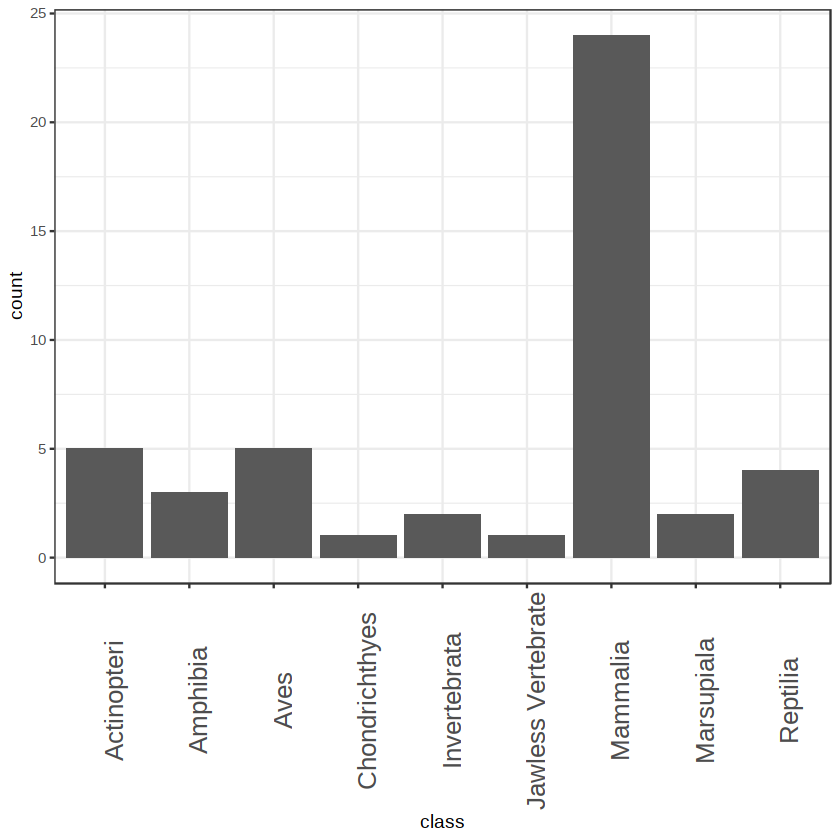

In [18]:
ggplot(annot_full, aes(x = class)) + geom_bar() + theme_bw() + theme(axis.text.x = element_text(angle = 90, size = 15))

In [19]:
for (i in 11:NROW(annot_full)){
    print(as.character(annot_full[i,]$species))
    #where to save tracks
    dir_out <- file.path(output_dir, "data", "tracks", annot_full[i,]$species)
    dir.create(dir_out)
    
    #new rtracklayer seccion
    mySession <- browserSession()
    genome(mySession) <- annot_full[i,]$ucsc_genome
    
    ##UCSC browser available tracks
    UCSCnames <- trackNames(ucscTableQuery(mySession))
    
    for (id in track_ids){
        if (!id %in% names(UCSCnames)) print(paste0(id, " unavaliable for ", as.character(annot_full[i,]$species), " ", annot_full[i,]$ucsc_genome))
        else{
            my_track <- track(ucscTableQuery(mySession, track=UCSCnames[id]))
            export.bed(my_track, file.path(dir_out, paste0(annot_full[i,]$ucsc_genome, "_", UCSCnames[id],".bed")))
        }
    }
    
   
    print(annot_full[i,]$ucsc_genome)
}

[1] "X. tropicalis"


Warning message in dir.create(dir_out):
“'/scratch/lab_bock/shared/projects/compEpi/validation/insilicoDigest//data/tracks/X. tropicalis' already exists”


[1] "RefSeq Genes unavaliable for X. tropicalis xenTro9"
[1] "xenTro9"
[1] "African clawed frog"


Warning message in dir.create(dir_out):
“'/scratch/lab_bock/shared/projects/compEpi/validation/insilicoDigest//data/tracks/African clawed frog' already exists”


[1] "RefSeq Genes unavaliable for African clawed frog xenLae2"
[1] "xenLae2"
[1] "Tibetan frog"


Warning message in dir.create(dir_out):
“'/scratch/lab_bock/shared/projects/compEpi/validation/insilicoDigest//data/tracks/Tibetan frog' already exists”


[1] "RefSeq Genes unavaliable for Tibetan frog nanPar1"
[1] "nanPar1"
[1] "American alligator"


Warning message in dir.create(dir_out):
“'/scratch/lab_bock/shared/projects/compEpi/validation/insilicoDigest//data/tracks/American alligator' already exists”


[1] "RefSeq Genes unavaliable for American alligator allMis1"
[1] "allMis1"
[1] "Garter snake"


Warning message in dir.create(dir_out):
“'/scratch/lab_bock/shared/projects/compEpi/validation/insilicoDigest//data/tracks/Garter snake' already exists”


[1] "RefSeq Genes unavaliable for Garter snake thaSir1"
[1] "thaSir1"
[1] "Lizard"
[1] "RefSeq Genes unavaliable for Lizard anoCar2"
[1] "anoCar2"
[1] "Painted turtle"
[1] "NCBI RefSeq unavaliable for Painted turtle chrPic1"
[1] "RefSeq Genes unavaliable for Painted turtle chrPic1"
[1] "chrPic1"
[1] "Chicken"
[1] "RefSeq Genes unavaliable for Chicken galGal6"
[1] "galGal6"
[1] "Zebra finch"
[1] "RefSeq Genes unavaliable for Zebra finch taeGut2"
[1] "taeGut2"
[1] "Medium ground finch"
[1] "RefSeq Genes unavaliable for Medium ground finch geoFor1"
[1] "geoFor1"
[1] "Budgeriger"
[1] "RefSeq Genes unavaliable for Budgeriger melUnd1"
[1] "melUnd1"
[1] "Golden eagle"
[1] "NCBI RefSeq unavaliable for Golden eagle aquChr2"
[1] "RefSeq Genes unavaliable for Golden eagle aquChr2"
[1] "aquChr2"
[1] "Tasmanian devil"
[1] "RefSeq Genes unavaliable for Tasmanian devil sarHar1"
[1] "sarHar1"
[1] "Opossum"
[1] "NCBI RefSeq unavaliable for Opossum monDom5"
[1] "monDom5"
[1] "Cow"
[1] "RefSeq Genes unav

In [49]:
download_track <- function(organism, genome, track_id, output_dir){
   mySession <- browserSession()
   genome(mySession) <- genome
    
   dir_out <- file.path(output_dir, "data", "tracks", organism)
    dir.create(dir_out)
   my_track <- track(ucscTableQuery(mySession, track=track_id))
   export.bed(my_track, file.path(dir_out, paste0(genome, "_", track_id,".bed")))
   
}

For some species the required genomes are not avaliable - we have to download the alternative tracks

### Lancelet

In [7]:
mySession <- browserSession()
genome(mySession) <- "braFlo1"
UCSCnames <- trackNames(ucscTableQuery(mySession))
UCSCnames

AUGUSTUS   Chicken Chain/Net        Conservation          GC Percent 
     "augustusGene"   "chainNetGalGal3"          "cons5way"           "gc5Base" 
                Gap     Human Chain/Net      Human Proteins   Lamprey Chain/Net 
              "gap"      "chainNetHg18"       "blastHg18KG"   "chainNetPetMar1" 
      Lancelet ESTs      Lancelet mRNAs     Mouse Chain/Net        Other RefSeq 
              "est"              "mrna"       "chainNetMm9"       "xenoRefGene" 
        Other mRNAs           Scaffolds      Simple Repeats        Spliced ESTs 
         "xenoMrna"              "gold"      "simpleRepeat"         "intronEst" 
            UniProt          WM + SDust 
          "uniprot" "windowmaskerSdust"

In [12]:
download_track("Lancelet", "braFlo1", "xenoRefGene", output_dir)

In [15]:
download_track("Lancelet", "braFlo1", "simpleRepeat", output_dir)

### Sea Hare

In [14]:
mySession <- browserSession()
genome(mySession) <- "aplCal1"
UCSCnames <- trackNames(ucscTableQuery(mySession))
UCSCnames

Assembly            CpG Islands             GC Percent 
                "gold"         "cpgIslandExt"              "gc5Base" 
                   Gap         Human Proteins       Interrupted Rpts 
                 "gap"          "blastHg18KG"        "nestedRepeats" 
        Microsatellite           Other RefSeq         Quality Scores 
            "microsat"          "xenoRefGene"              "quality" 
          RepeatMasker          Sea hare ESTs         Sea hare mRNAs 
                "rmsk"                  "est"                 "mrna" 
        Simple Repeats           Spliced ESTs                UniProt 
        "simpleRepeat"            "intronEst"              "uniprot" 
          Unmasked CpG 
"cpgIslandExtUnmasked"

In [16]:
download_track("Sea Hare", "aplCal1", "xenoRefGene", output_dir)

### Lamprey

Changed the genome assembly to 2

In [30]:
mySession <- browserSession()
genome(mySession) <- "petMar2"
UCSCnames <- trackNames(ucscTableQuery(mySession))
UCSCnames

AUGUSTUS                   Assembly 
            "augustusGene"                     "gold" 
         Chicken Chain/Net Chromosome Band (Ideogram) 
         "chainNetGalGal4"             "cytoBandIdeo" 
              Conservation                CpG Islands 
                "cons7way"             "cpgIslandExt" 
             Ensembl Genes                 GC Percent 
                 "ensGene"                "gc5BaseBw" 
                       Gap              Genscan Genes 
                     "gap"                  "genscan" 
           Human Chain/Net                      INSDC 
            "chainNetHg19"              "ucscToINSDC" 
          Interrupted Rpts               Lamprey ESTs 
           "nestedRepeats"                      "est" 
             Lamprey Genes              Lamprey mRNAs 
             "lampreyGene"                     "mrna" 
        Lancelet Chain/Net           Medaka Chain/Net 
         "chainNetBraFlo2"          "chainNetOryLat2" 
            Microsatellite            Mouse Chain/Net 
                "microsat"             "chainNetMm10" 
         Opossum Chain/Net               Other RefSeq 
         "chainNetMonDom5"              "xenoRefGene" 
              RepeatMasker             Simple Repeats 
                    "rmsk"             "simpleRepeat" 
              Spliced ESTs              TransMap ESTs 
               "intronEst"            "transMapEstV5" 
          TransMap Ensembl               TransMap RNA 
       "transMapEnsemblV5"            "transMapRnaV5" 
          TransMap RefGene               Unmasked CpG 
        "transMapRefSeqV5"     "cpgIslandExtUnmasked" 
                WM + SDust 
       "windowmaskerSdust"

In [31]:
download_track("Lamprey", "petMar2", "lampreyGene", output_dir)

In [32]:
download_track("Lamprey", "petMar2", "cpgIslandExt", output_dir)

In [33]:
download_track("Lamprey", "petMar2", "rmsk", output_dir)

In [48]:
mySession <- browserSession()
genome(mySession) <- "hg38"
UCSCnames <- trackNames(ucscTableQuery(mySession))
UCSCnames

1000 Genomes Trios               1000G Ph3 Vars 
                  "tgpTrios"                  "tgpPhase3" 
                    AUGUSTUS                   Affy GNF1H 
              "augustusGene"                  "affyGnf1h" 
                   Affy U133                     Affy U95 
                  "affyU133"                    "affyU95" 
             All GENCODE V22              All GENCODE V23 
        "wgEncodeGencodeV22"         "wgEncodeGencodeV23" 
             All GENCODE V24              All GENCODE V25 
        "wgEncodeGencodeV24"         "wgEncodeGencodeV25" 
             All GENCODE V26              All GENCODE V27 
        "wgEncodeGencodeV26"         "wgEncodeGencodeV27" 
             All GENCODE V28              All GENCODE V29 
        "wgEncodeGencodeV28"         "wgEncodeGencodeV29" 
             All GENCODE V31              All GENCODE V33 
        "wgEncodeGencodeV31"         "wgEncodeGencodeV33" 
             All GENCODE V34                All SNPs(141) 
        "wgEncodeGencodeV34"                     "snp141" 
               All SNPs(142)                All SNPs(144) 
                    "snp142"                     "snp144" 
               All SNPs(146)                All SNPs(147) 
                    "snp146"                     "snp147" 
               All SNPs(150)                All SNPs(151) 
                    "snp150"                     "snp151" 
              Alt Haplotypes                     Assembly 
         "altSeqLiftOverPsl"                       "gold" 
                      Bismap                         CCDS 
                    "bismap"                   "ccdsGene" 
               COVID GWAS v3                COVID GWAS v4 
              "covidHgiGwas"         "covidHgiGwasR4Pval" 
              CRISPR Targets             Cancer Gene Expr 
          "crisprAllTargets"               "tcgaGeneExpr" 
          Cancer Transc Expr                  Centromeres 
            "tcgaTranscExpr"                "centromeres" 
             Chromosome Band   Chromosome Band (Ideogram) 
                  "cytoBand"               "cytoBandIdeo" 
                     ClinGen                 ClinGen CNVs 
               "clinGenComp"              "iscaComposite" 
            ClinVar Variants                   Clone Ends 
                   "clinvar"              "cloneEndSuper" 
            Common SNPs(141)             Common SNPs(142) 
              "snp141Common"               "snp142Common" 
            Common SNPs(144)             Common SNPs(146) 
              "snp144Common"               "snp146Common" 
            Common SNPs(147)             Common SNPs(150) 
              "snp147Common"               "snp150Common" 
            Common SNPs(151)              Cons 20 Mammals 
              "snp151Common"                  "cons20way" 
            Cons 30 Primates                 Cons 7 Verts 
                 "cons30way"                   "cons7way" 
                Conservation                 Coriell CNVs 
                "cons100way"              "coriellDelDup" 
                 CpG Islands               DGV Struct Var 
              "cpgIslandExt"                    "dgvPlus" 
              DNase Clusters                     DNase HS 
 "wgEncodeRegDnaseClustered"           "wgEncodeRegDnase" 
                DNase Signal            Development Delay 
       "wgEncodeRegDnaseWig"                "cnvDevDelay" 
                ENCODE cCREs             EPDnew Promoters 
        "encodeCcreCombined"                     "epdNew" 
                 FISH Clones                  Fix Patches 
                "fishClones"          "fixSeqLiftOverPsl" 
           Flagged SNPs(141)            Flagged SNPs(142) 
             "snp141Flagged"              "snp142Flagged" 
           Flagged SNPs(144)            Flagged SNPs(146) 
             "snp144Flagged"              "snp146Flagged" 
           Flagged SNPs(147)            Flagged SNPs(150) 
             "snp147Flagged"              "snp150Flagged"

In [51]:
download_track("Human", "hg38", "rmsk", output_dir)

In [54]:
UCSCnames[track_ids]

CpG Islands       NCBI RefSeq              <NA>      RepeatMasker 
   "cpgIslandExt" "refSeqComposite"                NA            "rmsk"

In [55]:
download_track("Human", "hg38", "refSeqComposite", output_dir)

Warning message in dir.create(dir_out):
“'/scratch/lab_bock/shared/projects/compEpi/validation/insilicoDigest//data/tracks/Human' already exists”


In [57]:
download_track("Human", "hg38", "cpgIslandExt", output_dir)

Warning message in dir.create(dir_out):
“'/scratch/lab_bock/shared/projects/compEpi/validation/insilicoDigest//data/tracks/Human' already exists”


UCSCnameslantic cod

In [20]:
mySession <- browserSession()
genome(mySession) <- "gadMor1"
UCSCnames <- trackNames(ucscTableQuery(mySession))
UCSCnames

AUGUSTUS                   Assembly 
            "augustusGene"                     "gold" 
         Atlantic cod ESTs         Atlantic cod mRNAs 
                     "est"                     "mrna" 
Chromosome Band (Ideogram)                CpG Islands 
            "cytoBandIdeo"             "cpgIslandExt" 
          Ensembl Assembly              Ensembl Genes 
     "ensemblGeneScaffold"                  "ensGene" 
            Fugu Chain/Net                 GC Percent 
             "chainNetFr3"                "gc5BaseBw" 
                       Gap              Genscan Genes 
                     "gap"                  "genscan" 
                     INSDC           Interrupted Rpts 
             "ucscToINSDC"            "nestedRepeats" 
            Microsatellite            Mouse Chain/Net 
                "microsat"             "chainNetMm10" 
              Other RefSeq               RepeatMasker 
             "xenoRefGene"                     "rmsk" 
            Simple Repeats               Spliced ESTs 
            "simpleRepeat"                "intronEst" 
             TransMap ESTs           TransMap Ensembl 
           "transMapEstV5"        "transMapEnsemblV5" 
              TransMap RNA           TransMap RefGene 
           "transMapRnaV5"         "transMapRefSeqV5" 
                   UniProt               Unmasked CpG 
                 "uniprot"     "cpgIslandExtUnmasked" 
                WM + SDust 
       "windowmaskerSdust"

In [21]:
download_track("Atlantic cod", "gadMor1", "ensGene", output_dir)

In [22]:
download_track("Painted turtle", "chrPic1", "genscan", output_dir)

In [23]:
download_track("Golden eagle", "aquChr2", "genscan", output_dir)

In [24]:
download_track("Gibbon", "nomLeu3", "ensGene", output_dir)

In [25]:
download_track("Megabat", "pteVam1", "ensGene", output_dir)

In [26]:
download_track("Orangutan", "ponAbe3", "simpleRepeat", output_dir)

In [27]:
download_track("Tree shrew", "tupBel1", "ensGene", output_dir)

In [28]:
download_track("Wallaby", "macEug2", "genscan", output_dir)

Summary:

In [12]:
df_full =read.table("../meta/validation_species_resources.csv", sep = ";", header = 1 )

In [13]:
head(df_full)

,species,ucsc_genome,class,scientific_name,date,name,BSlibrary,genome_id,provider
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,Mouse,mm10,Mammalia,Mus musculus,Dec. 2011,Genome Reference Consortium GRCm38,BSgenome.Mmusculus.UCSC.mm10,Mmusculus,UCSC
2,Zebrafish,danRer11,Actinopteri,Danio rerio,May 2017,Genome Reference Consortium GRCz11,BSgenome.Drerio.UCSC.danRer11,Drerio,UCSC
3,Chicken,galGal6,Aves,Gallus gallus,Mar. 2018,GRCg6 Gallus-gallus-6.0,BSgenome.Ggallus.UCSC.galGal6,Ggallus,UCSC
4,Zebra finch,taeGut2,Aves,Taeniopygia guttata,Feb. 2013,WashU taeGut324,BSgenome.Tguttata.UCSC.taeGut2,Tguttata,UCSC
5,Opossum,monDom5,Marsupiala,Monodelphis domestica,Oct. 2006,Broad Institute release MonDom5,BSgenome.Mdomestica.UCSC.monDom5,Mdomestica,UCSC
6,Cow,bosTau9,Mammalia,Bos taurus,Apr. 2018,USDA ARS,BSgenome.Btaurus.UCSC.bosTau9,Btaurus,UCSC


In [33]:
get_tracks <- function(sp_list){
tracks <- list.files(file.path(output_dir, "data", "tracks", sp_list))
s <- paste0(as.character(sapply(tracks, function(x) strsplit(gsub("*_", "",x),  "\\.")[[1]][1])), 
                                collapse = ",")
return(s)}

In [34]:
get_tracks(df_full$species[[2]])

[1] "danRer11cpgIslandExt,danRer11refSeqComposite,danRer11rmsk"

In [36]:
df_full["tracks_UCSC"] <- sapply(df_full$species, get_tracks)

In [38]:
write.table(df_full, "../meta//validation_species_resources_forST.csv", sep = ";", row.names = F, quote = F)

### Validate the chrom sizes:

Reading the annotation dataframe:

In [25]:
df_full <- read.table("../meta//validation_species_resources.csv", sep = ";", header = 1)
head(df_full)

species,ucsc_genome,class,scientific_name,date,name,BSlibrary,genome_id,provider
Human,hg38,Mammalia,Homo sapiens,Dec. 2013,Genome Reference Consortium GRCm38,BSgenome.Hsapiens.UCSC.hg38,Hsapiens,UCSC
Mouse,mm10,Mammalia,Mus musculus,Dec. 2011,Genome Reference Consortium GRCm38,BSgenome.Mmusculus.UCSC.mm10,Mmusculus,UCSC
Zebrafish,danRer11,Actinopteri,Danio rerio,May 2017,Genome Reference Consortium GRCz11,BSgenome.Drerio.UCSC.danRer11,Drerio,UCSC
Chicken,galGal6,Aves,Gallus gallus,Mar. 2018,GRCg6 Gallus-gallus-6.0,BSgenome.Ggallus.UCSC.galGal6,Ggallus,UCSC
Zebra finch,taeGut2,Aves,Taeniopygia guttata,Feb. 2013,WashU taeGut324,BSgenome.Tguttata.UCSC.taeGut2,Tguttata,UCSC
Opossum,monDom5,Marsupiala,Monodelphis domestica,Oct. 2006,Broad Institute release MonDom5,BSgenome.Mdomestica.UCSC.monDom5,Mdomestica,UCSC


For each of the genomes we are going to download the file with the chrom sizes, and evaluate the number of "short" chromosomes that are in the genome

In [65]:
chrLengthStats = data.table()

In [67]:
for (i in 1:NROW(df_full)){
    url = paste0("http://hgdownload.soe.ucsc.edu/goldenPath/", df_full$ucsc_genome[[i]], "/bigZips/", df_full$ucsc_genome[[i]], ".chrom.sizes")
    df <- fread(url)
    colnames(df) <- c("chrN", "chrSize")
    
    N <- colSums(df[, 2])
    
    if(NROW(df) > 100) N_100 <- colSums(df[order(-chrSize)][c(1:100), 2])
    else N_100 = N
    
    ans_row <- data.frame("Name" = as.character(df_full$species[[i]]),"genome" = as.character(df_full$ucsc_genome[[i]]), "nchr" = NROW(df), 
                          "chrSumLength" = N, "chrSumLength_100" = N_100)
    #print(ans_row)
    print(df_full$species[[i]])
    chrLengthStats <- rbind(chrLengthStats, ans_row)
}

[1] Human
48 Levels: African clawed frog American alligator Atlantic cod ... Zebrafish
[1] Mouse
48 Levels: African clawed frog American alligator Atlantic cod ... Zebrafish
[1] Zebrafish
48 Levels: African clawed frog American alligator Atlantic cod ... Zebrafish
[1] Chicken
48 Levels: African clawed frog American alligator Atlantic cod ... Zebrafish
[1] Zebra finch
48 Levels: African clawed frog American alligator Atlantic cod ... Zebrafish
[1] Opossum
48 Levels: African clawed frog American alligator Atlantic cod ... Zebrafish
[1] Cow
48 Levels: African clawed frog American alligator Atlantic cod ... Zebrafish
[1] Dog
48 Levels: African clawed frog American alligator Atlantic cod ... Zebrafish
[1] Ferret
48 Levels: African clawed frog American alligator Atlantic cod ... Zebrafish
[1] Chimp
48 Levels: African clawed frog American alligator Atlantic cod ... Zebrafish
[1] Pig
48 Levels: African clawed frog American alligator Atlantic cod ... Zebrafish
[1] Rhesus
48 Levels: African claw

In [68]:
chrLengthStats

Name,genome,nchr,chrSumLength,chrSumLength_100
Human,hg38,455,3209286105,3171759732
Mouse,mm10,66,2730871774,2730871774
Zebrafish,danRer11,1923,1679203469,1390091111
Chicken,galGal6,464,1065365425,1062298020
Zebra finch,taeGut2,37096,1232135591,1047003328
Opossum,monDom5,11,3605631728,3605631728
Cow,bosTau9,2211,2715853792,2657896138
Dog,canFam3,3268,2410976875,2356725059
Ferret,musFur1,7741,2410758013,1458360456
Chimp,panTro6,4346,3050398082,2888958340


In [73]:
chrLengthStats[nchr > 10000]

Name,genome,nchr,chrSumLength,chrSumLength_100
Zebra finch,taeGut2,37096,1232135591,1047003328
Lamprey,petMar2,25006,885550958,109348046
Elephant shark,calMil1,21204,974498586,638515969
Atlantic cod,gadMor1,427428,824327835,199448216
Coelacanth,latCha1,22819,2860591921,375225220
African clawed frog,xenLae2,108033,2718433805,2645391720
Tibetan frog,nanPar1,25187,2053849526,337425731
American alligator,allMis1,14645,2174259888,200330421
Painted turtle,chrPic1,80984,2589745704,1017560360
Medium ground finch,geoFor1,27239,1065292181,706642168


In [78]:
write.table(chrLengthStats, file.path(output_dir, "chromSizeStats.tsv"), sep = "\t", quote = F)